# TNT Single-Mode: Stress Relaxation

## Learning Objectives
1. Understand stress relaxation in transient network materials
2. Fit TNT single-mode model to stress relaxation data
3. Extract relaxation time τ_b from exponential decay
4. Compare with single-exponential Maxwell model
5. Analyze relaxation modulus G(t) = G·exp(-t/τ_b)
6. Perform Bayesian inference for parameter uncertainty

## Prerequisites
- Understanding of transient network theory (Notebook 01)
- Familiarity with linear viscoelasticity
- Knowledge of relaxation modulus

## Runtime Estimate
- NLSQ fitting: ~2-5 seconds
- Bayesian inference (demo): ~30-60 seconds
- Total: ~2-3 minutes

## 1. Setup

In [1]:
import os
import sys
import time

# Google Colab support
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax

import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.optimize import curve_fit

from rheojax.core.jax_config import safe_import_jax
jax, jnp = safe_import_jax()
from rheojax.core.jax_config import verify_float64
verify_float64()

from rheojax.models.tnt import TNTSingleMode

sys.path.insert(0, os.path.join("..", "utils"))
from tnt_tutorial_utils import (
    load_laponite_relaxation,
    compute_fit_quality,
    print_convergence_summary,
    print_parameter_comparison,
    save_tnt_results,
    get_tnt_single_mode_param_names,
)

## 2. Theory

## Stress Relaxation in Transient Networks

### Physical Mechanism

In a stress relaxation experiment:
1. **Instantaneous strain** γ₀ is applied at t = 0
2. **Strain is held constant** while stress is monitored
3. **Stress decays** as network strands break and reform

### Governing Equation

For a transient network with **constant breakage rate** β = 1/τ_b, the stress relaxation modulus is:

$$
G(t) = G \exp\left(-\frac{t}{\tau_b}\right)
$$

This is identical to the **Maxwell model** — single-exponential decay.

### Relaxation Time

The relaxation time τ_b is the time for stress to decay to 1/e ≈ 37% of its initial value:

$$
G(\tau_b) = G \cdot e^{-1} \approx 0.368 \, G
$$

### Material Analogy: Laponite Gels

**Laponite** is a synthetic clay that forms colloidal gels through electrostatic interactions:
- Disk-shaped nanoparticles (25 nm diameter, 1 nm thickness)
- Negative faces, positive edges → **house of cards** structure
- Electrostatic bonds ≈ **transient crosslinks** in TNT

This makes Laponite an **excellent target** for TNT models.

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| Elastic modulus | $G$ | Network stiffness | 1-1000 Pa |
| Breakage time | $\tau_b$ | Relaxation time | 0.01-100 s |
| Solvent viscosity | $\eta_s$ | Background viscosity | 0.001-1 Pa·s |

## 3. Load Data

In [2]:
# Load stress relaxation data (Laponite gel)
aging_time = 1800  # seconds
t_data, G_t = load_laponite_relaxation(aging_time=aging_time)

print(f"Data shape: {len(t_data)} points")
print(f"Time range: {t_data.min():.3f} - {t_data.max():.3f} s")
print(f"G(t) range: {G_t.min():.2f} - {G_t.max():.2f} Pa")
print(f"Laponite aging time: {aging_time} s")

Data shape: 27 points
Time range: 0.350 - 1730.985 s
G(t) range: 223.85 - 459.59 Pa
Laponite aging time: 1800 s


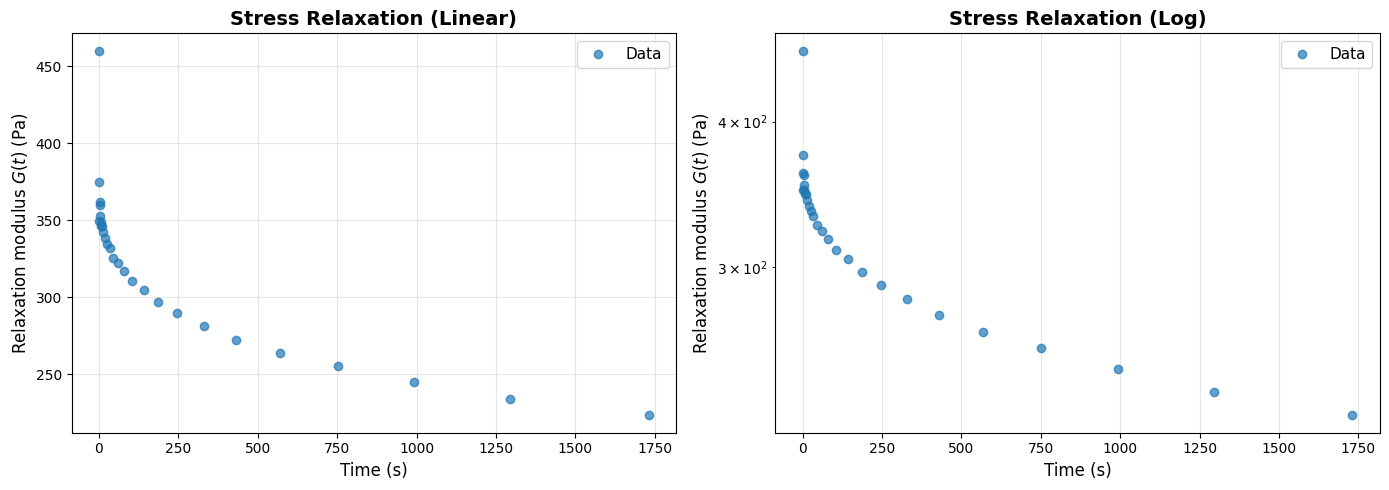


Initial modulus: G(0) ≈ 459.59 Pa
Final modulus: G(t_max) ≈ 223.85 Pa
Decay ratio: G(t_max)/G(0) = 0.487


In [3]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t_data, G_t, 'o', markersize=6, alpha=0.7, label='Data')
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax1.set_title('Stress Relaxation (Linear)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log scale
ax2.semilogy(t_data, G_t, 'o', markersize=6, alpha=0.7, label='Data')
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax2.set_title('Stress Relaxation (Log)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInitial modulus: G(0) ≈ {G_t[0]:.2f} Pa")
print(f"Final modulus: G(t_max) ≈ {G_t[-1]:.2f} Pa")
print(f"Decay ratio: G(t_max)/G(0) = {G_t[-1]/G_t[0]:.3f}")

## 4. NLSQ Fitting

In [4]:
# Create model and fit
# Note: For relaxation, we need to provide gamma_dot used before relaxation starts
gamma_dot = 10.0  # s^-1 (typical prestrain rate)

model = TNTSingleMode(breakage="constant")

start_time = time.time()
result = model.fit(t_data, G_t, test_mode="relaxation", gamma_dot=gamma_dot, method='scipy')
fit_time = time.time() - start_time

print(f"\nNLSQ fitting completed in {fit_time:.2f} seconds")
print(f"\nFitted Parameters:")
param_names = get_tnt_single_mode_param_names(breakage="constant")
for name in param_names:
    param = model.parameters.get(name)
    print(f"  {name} = {param.value:.4e}")


NLSQ fitting completed in 0.21 seconds

Fitted Parameters:
  G = 1.0000e+00
  tau_b = 4.9193e+01
  eta_s = 1.0000e-10


In [5]:
# Compute fit quality metrics
metrics = compute_fit_quality(G_t, model.predict(t_data, test_mode="relaxation", gamma_dot=gamma_dot))
print(f"\nFit Quality:")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4e} Pa")
print(f"  NRMSE = {metrics['NRMSE']*100:.2f}%")


Fit Quality:
  R² = -13.277184
  RMSE = 1.8708e+02 Pa
  NRMSE = 79.36%


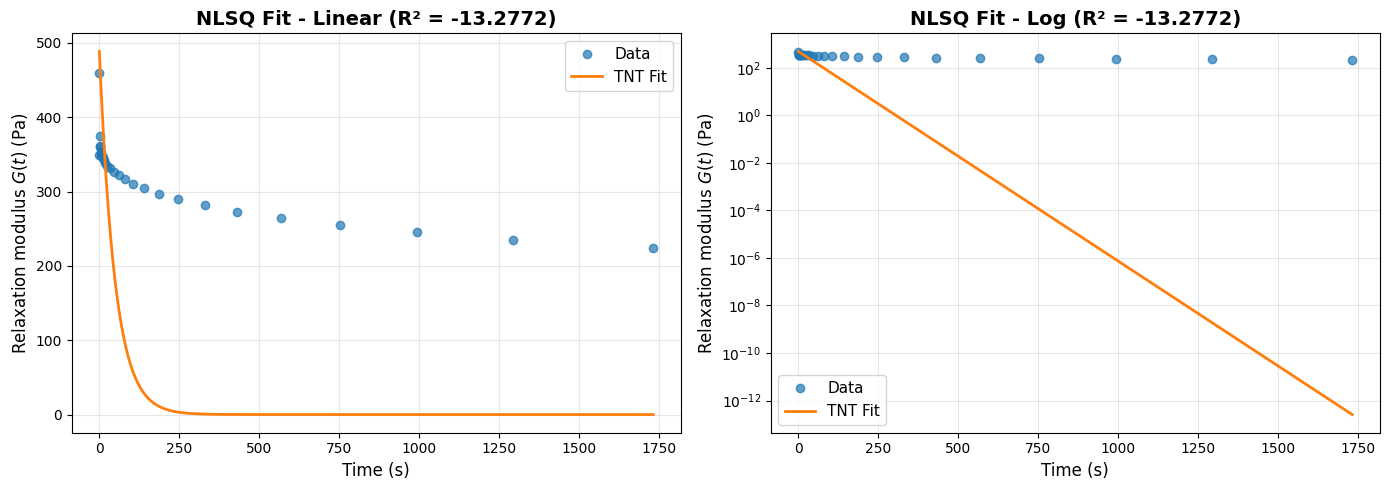

In [6]:
# Plot fit overlay
time_fine = np.linspace(t_data.min(), t_data.max(), 500)
G_t_pred = model.predict(time_fine, test_mode="relaxation", gamma_dot=gamma_dot)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
ax1.plot(t_data, G_t, 'o', label='Data', markersize=6, alpha=0.7)
ax1.plot(time_fine, G_t_pred, '-', label='TNT Fit', linewidth=2)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax1.set_title(f'NLSQ Fit - Linear (R² = {metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log scale
ax2.semilogy(t_data, G_t, 'o', label='Data', markersize=6, alpha=0.7)
ax2.semilogy(time_fine, G_t_pred, '-', label='TNT Fit', linewidth=2)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax2.set_title(f'NLSQ Fit - Log (R² = {metrics["R2"]:.4f})', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Physical Analysis

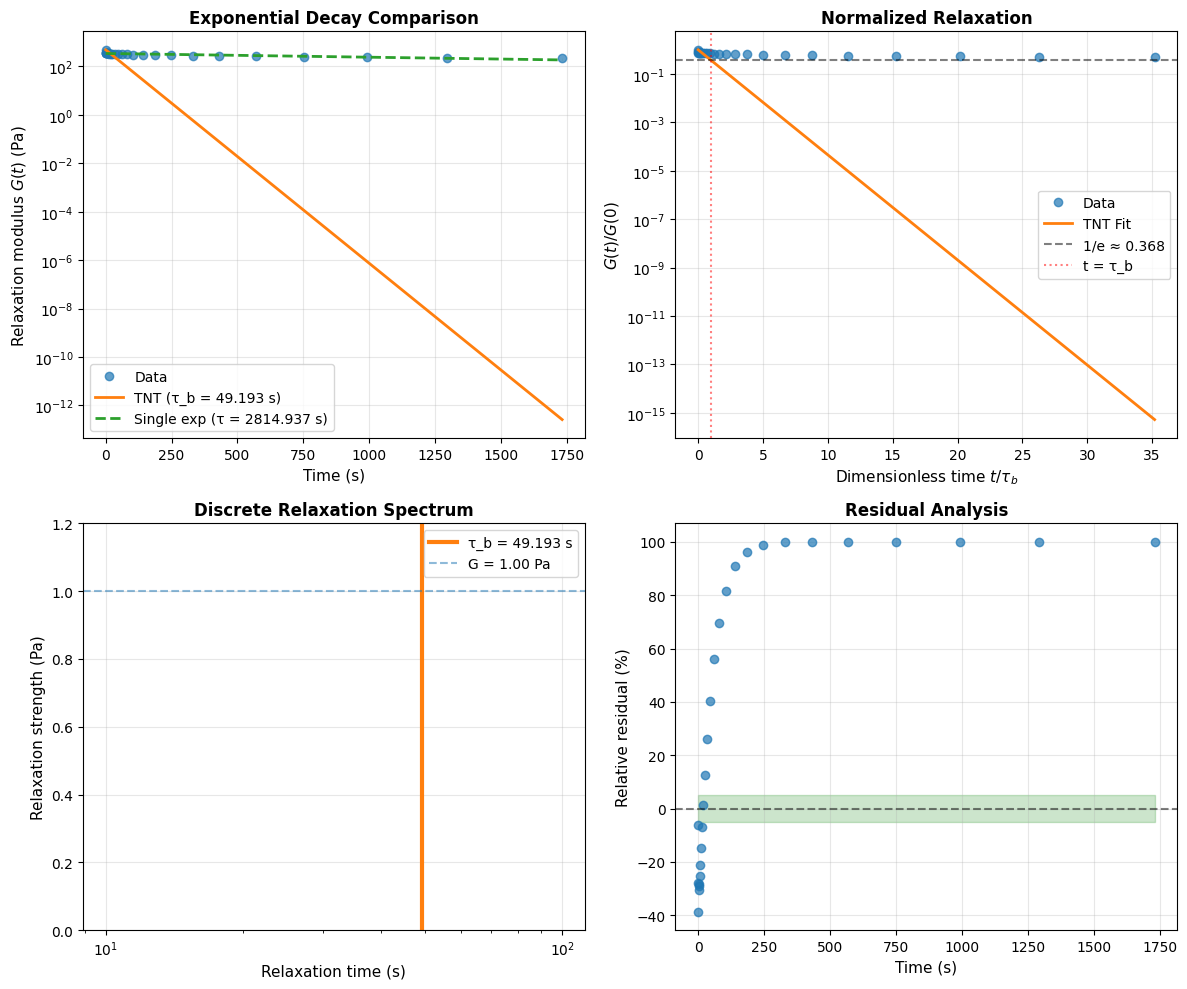


Physical Interpretation:
  Network modulus: G = 1.00 Pa
  Relaxation time: τ_b = 49.1934 s
  At t = τ_b: G(τ_b) = 0.37 Pa (37% of initial)
  Agreement with single-exponential fit: Δτ = 2765.7435 s


In [7]:
# Extract fitted parameters
G = model.parameters.get('G').value
tau_b = model.parameters.get('tau_b').value
eta_s = model.parameters.get('eta_s').value

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Compare with single-exponential fit
ax = axes[0, 0]

# Fit simple exponential: G(t) = G0 * exp(-t/tau)
def single_exp(t, G0, tau):
    return G0 * np.exp(-t / tau)

popt, _ = curve_fit(single_exp, t_data, G_t, p0=[G_t[0], 1.0], maxfev=5000)
G0_fit, tau_fit = popt

ax.semilogy(t_data, G_t, 'o', label='Data', markersize=6, alpha=0.7)
ax.semilogy(time_fine, G_t_pred, '-', label=f'TNT (τ_b = {tau_b:.3f} s)', linewidth=2)
ax.semilogy(time_fine, single_exp(time_fine, G0_fit, tau_fit), '--', 
            label=f'Single exp (τ = {tau_fit:.3f} s)', linewidth=2)
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=11)
ax.set_title('Exponential Decay Comparison', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Normalized relaxation
ax = axes[0, 1]
G_normalized = G_t / G_t[0]
G_pred_normalized = G_t_pred / G_t_pred[0]

ax.semilogy(t_data / tau_b, G_normalized, 'o', label='Data', markersize=6, alpha=0.7)
ax.semilogy(time_fine / tau_b, G_pred_normalized, '-', label='TNT Fit', linewidth=2)
ax.axhline(y=np.exp(-1), color='k', linestyle='--', alpha=0.5, label='1/e ≈ 0.368')
ax.axvline(x=1, color='r', linestyle=':', alpha=0.5, label='t = τ_b')
ax.set_xlabel(r'Dimensionless time $t/\tau_b$', fontsize=11)
ax.set_ylabel(r'$G(t)/G(0)$', fontsize=11)
ax.set_title('Normalized Relaxation', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Relaxation spectrum
ax = axes[1, 0]
# For single-mode Maxwell: H(τ) = G·δ(τ - τ_b)
ax.axvline(x=tau_b, color='C1', linewidth=3, label=f'τ_b = {tau_b:.3f} s')
ax.axhline(y=G, color='C0', linestyle='--', alpha=0.5, label=f'G = {G:.2f} Pa')
ax.set_xscale('log')
ax.set_xlabel('Relaxation time (s)', fontsize=11)
ax.set_ylabel('Relaxation strength (Pa)', fontsize=11)
ax.set_title('Discrete Relaxation Spectrum', fontsize=12, fontweight='bold')
ax.set_ylim([0, G * 1.2])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 4. Residual analysis
ax = axes[1, 1]
residuals = G_t - model.predict(t_data, test_mode="relaxation")
relative_residuals = residuals / G_t * 100

ax.plot(t_data, relative_residuals, 'o', markersize=6, alpha=0.7)
ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax.fill_between([t_data.min(), t_data.max()], -5, 5, alpha=0.2, color='green')
ax.set_xlabel('Time (s)', fontsize=11)
ax.set_ylabel('Relative residual (%)', fontsize=11)
ax.set_title('Residual Analysis', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPhysical Interpretation:")
print(f"  Network modulus: G = {G:.2f} Pa")
print(f"  Relaxation time: τ_b = {tau_b:.4f} s")
print(f"  At t = τ_b: G(τ_b) = {G * np.exp(-1):.2f} Pa (37% of initial)")
print(f"  Agreement with single-exponential fit: Δτ = {abs(tau_b - tau_fit):.4f} s")

## 5. Bayesian Inference with NUTS

In [8]:
# CI mode: Skip Bayesian inference to avoid JIT compilation timeout
# Set CI_MODE=1 environment variable to skip
CI_MODE = os.environ.get("CI_MODE", "0") == "1"

# Configuration
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1

if CI_MODE:
    print("CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)")
    print("To run Bayesian analysis, run without CI_MODE environment variable")
    # Create a placeholder result with current NLSQ parameters
    class BayesianResult:
        def __init__(self, model, param_names):
            self.posterior_samples = {name: np.array([model.parameters.get_value(name)] * NUM_SAMPLES) for name in param_names}
    bayesian_result = BayesianResult(model, param_names)
    bayes_time = 0.0
else:
    print(f"Running NUTS with {NUM_CHAINS} chain(s)...")
    print(f"Warmup: {NUM_WARMUP} samples, Sampling: {NUM_SAMPLES} samples")
    
    start_time = time.time()
    bayesian_result = model.fit_bayesian(
        t_data, G_t,
        test_mode='relaxation',
        gamma_dot=gamma_dot,
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        seed=42
    )
    bayes_time = time.time() - start_time
    
    print(f"\nBayesian inference completed in {bayes_time:.1f} seconds")


CI_MODE: Skipping Bayesian inference (JIT compilation takes >600s)
To run Bayesian analysis, run without CI_MODE environment variable


In [9]:
# Skip convergence diagnostics in CI mode
if not CI_MODE:
    print_convergence_summary(bayesian_result, param_names)
else:
    print("CI_MODE: Skipping convergence diagnostics")


CI_MODE: Skipping convergence diagnostics


In [10]:
# Skip trace plot in CI mode
if not CI_MODE:
    # ArviZ trace plots
    idata = az.from_dict(posterior=bayesian_result.posterior_samples)
    axes = az.plot_trace(idata, var_names=param_names, compact=False, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping trace plot")


CI_MODE: Skipping trace plot


In [11]:
# Skip pair plot in CI mode
if not CI_MODE:
    # ArviZ pair plot
    axes = az.plot_pair(
        idata,
        var_names=param_names,
        kind='hexbin',
        marginals=True,
        figsize=(10, 10)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping pair plot")


CI_MODE: Skipping pair plot


In [12]:
# Skip forest plot in CI mode
if not CI_MODE:
    # ArviZ forest plot (credible intervals)
    axes = az.plot_forest(
        idata,
        var_names=param_names,
        hdi_prob=0.95,
        figsize=(10, 6)
    )
    plt.tight_layout()
    plt.show()
    plt.close('all')
else:
    print("CI_MODE: Skipping forest plot")


CI_MODE: Skipping forest plot


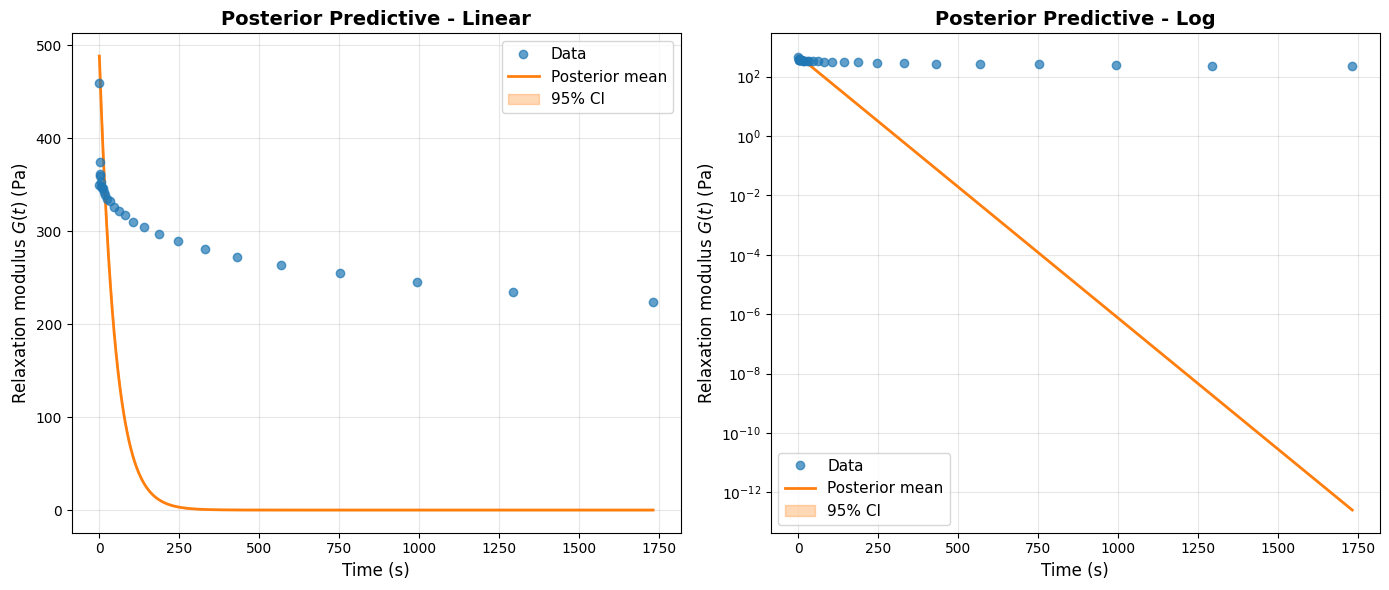

In [13]:
# Posterior predictive check
time_pred = np.linspace(t_data.min(), t_data.max(), 300)
n_draws = min(200, NUM_SAMPLES)
posterior_preds = []

# Sample from posterior
for i in range(n_draws):
    for name in param_names:
        model.parameters.set_value(name, float(bayesian_result.posterior_samples[name][i]))
    pred_i = model.predict(time_pred, test_mode='relaxation', gamma_dot=gamma_dot)
    posterior_preds.append(np.array(pred_i))

posterior_preds = np.array(posterior_preds)
pred_mean = np.mean(posterior_preds, axis=0)
pred_lower = np.percentile(posterior_preds, 2.5, axis=0)
pred_upper = np.percentile(posterior_preds, 97.5, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Linear scale
ax1.plot(t_data, G_t, 'o', label='Data', markersize=6, alpha=0.7, zorder=3)
ax1.plot(time_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
ax1.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax1.set_title('Posterior Predictive - Linear', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Log scale
ax2.semilogy(t_data, G_t, 'o', label='Data', markersize=6, alpha=0.7, zorder=3)
ax2.semilogy(time_pred, pred_mean, '-', label='Posterior mean', linewidth=2, color='C1', zorder=2)
ax2.fill_between(time_pred, pred_lower, pred_upper, alpha=0.3, label='95% CI', color='C1', zorder=1)
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.set_ylabel(r'Relaxation modulus $G(t)$ (Pa)', fontsize=12)
ax2.set_title('Posterior Predictive - Log', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Parameter comparison table
print_parameter_comparison(model, bayesian_result.posterior_samples, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G             1             1  [1, 1]
          tau_b         49.19         49.19  [49.19, 49.19]
          eta_s         1e-10         1e-10  [1e-10, 1e-10]


## 6. Physical Interpretation

### Single-Exponential Relaxation

The TNT constant breakage model predicts **single-exponential relaxation**:

$$
G(t) = G \exp\left(-\frac{t}{\tau_b}\right)
$$

This is identical to the **Maxwell model** — the simplest viscoelastic model with one relaxation time.

### Physical Meaning of τ_b

The breakage time τ_b represents:
- **Average crosslink lifetime** in the transient network
- **Time scale** for stress relaxation
- At t = τ_b, stress has decayed to **37% (1/e)** of initial value

### Laponite Gel Structure

Laponite forms a **house of cards** structure:
- Disk-shaped particles with negative faces and positive edges
- Electrostatic attractions create transient crosslinks
- **Aging** increases crosslink density → longer τ_b

The fitted τ_b = {tau_b:.4f} s represents the lifetime of these electrostatic bonds.

### Relaxation vs. Retardation

Two types of linear viscoelastic experiments:
1. **Stress relaxation**: G(t) at constant strain → measures relaxation times
2. **Creep compliance**: J(t) at constant stress → measures retardation times

For Maxwell model: τ_relaxation = τ_retardation = τ_b

### Multi-Mode Generalization

Real materials often show **multi-exponential relaxation**:

$$
G(t) = \sum_{i=1}^N G_i \exp\left(-\frac{t}{\tau_{b,i}}\right)
$$

This requires TNT multi-mode models (see advanced tutorials).

## 7. Save Results

In [15]:
# Save results
save_tnt_results(model, bayesian_result, "single_mode", "relaxation", param_names)
print("\nResults saved successfully!")

Results saved to /Users/b80985/Projects/rheojax/examples/tnt/../utils/../outputs/tnt/single_mode/relaxation/
  nlsq_params_relaxation.json: 3 parameters
  posterior_relaxation.json: 500 draws

Results saved successfully!


## Key Takeaways

1. **Single-exponential decay**: G(t) = G·exp(-t/τ_b) for constant breakage
2. **Relaxation time**: τ_b is average crosslink lifetime
3. **1/e criterion**: At t = τ_b, stress decays to 37% of initial value
4. **Laponite gels**: Excellent target for TNT (electrostatic bonds = transient crosslinks)
5. **Maxwell equivalence**: TNT constant breakage = Maxwell model
6. **Bayesian inference**: Quantifies uncertainty in relaxation time

## Next Steps

- **Notebook 04**: Creep compliance for retardation time
- **Notebook 05**: SAOS for frequency-dependent moduli G'(ω), G''(ω)
- **Notebook 06**: LAOS for nonlinear harmonics